In [1]:
import numpy as np
from keras import backend as K
from keras import losses
import tensorflow as tf

Using TensorFlow backend.


In [2]:
x = np.array([2, -1, 3, -2, 2, 2, 1, -4, 5, 1])
w = np.array([-1, -1, 1, -1, 1, -1, 1, 1, -1, 1])

## Toy Example showing the phenomenal of fool a binary logistic  regression

'p' is the probability of be class 1.
If p > 0.5 it belongs to the class 1 otherwise not.

In [3]:
p = 1/(1+np.power(np.e, -np.dot(x, w)))
print(p)

0.04742587317756679


#### Let's try to foll the classifier

Doing the dot product again we see that suddenly the score becomes 2. This is not surprising: There are 10 dimensions and we’ve tweaked the input by 0.5 in every dimension in such a way that we gain 0.5 in each one, adding up to a total of 5 additional score, rising it from -3 to 2. Now when we look at probability of class 1 we get 1/(1+e^(-2)) = 0.88. That is, we tweaked the original x by a small amount and we improved the class 1 probability from 5% to 88%!

In [4]:
# xad = x + 0.5w gives:
xad = [1.5, -1.5, 3.5, -2.5, 2.5, 1.5, 1.5, -3.5, 4.5, 1.5]
# xad = [1.1, -1.1, 3.1, -2.1, 2.1, 1.1, 1.1, -3.1, 4.1, 1.1]

In [5]:
p = 1/(1+np.power(np.e, -np.dot(xad, w)))
print(p)

0.8807970779778823


## Reproducing the  “Deep MNIST for Experts” tutorial

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [7]:
def plot_figures(X_10_samples_2, X_10_noise):
    figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    fig = plt.figure(figsize=(30,15))

    idx_img = 0;
    for i in range(1, 30, 3):
        ax1 = fig.add_subplot(10, 3, i)
        ax1.imshow(X_10_samples_2[idx_img])
        ax2 = fig.add_subplot(10, 3, i+1)
        ax2.imshow(X_10_noise[idx_img])
        ax3 = fig.add_subplot(10, 3, i+2)
        ax3.imshow( (X_10_samples_2[idx_img] + X_10_noise[idx_img]) )

        idx_img = idx_img + 1

In [8]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
arange_ = np.arange(len(y_train))

In [9]:
# with tf.device('/cpu:0'):
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
y_aux = np.zeros( (len(y_train), 10) )
y_aux[arange_, y_train] = 1
y_train = y_aux
model.fit(x_train, y_train, epochs=5)


for i in range(len(model.layers)):
    layer = model.layers[i]
    layer.trainable = False

model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

model.summary()

dist_loss = K.variable(0.)
fake_class = K.variable(0)
K.set_session(tf.Session(graph=model.output.graph))
init = K.tf.global_variables_initializer()
K.get_session().run(init)

arange_ = np.arange(len(y_test))
y_aux = np.zeros( (len(y_test), 10) )
y_aux[arange_, y_test] = 1
y_test = y_aux

model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 12s 203us/step - loss: 0.2239 - acc: 0.9331
Epoch 2/5
60000/60000 [==============================] - 13s 213us/step - loss: 0.0982 - acc: 0.9702
Epoch 3/5
60000/60000 [==============================] - 12s 203us/step - loss: 0.0685 - acc: 0.9786
Epoch 4/5
60000/60000 [==============================] - 12s 199us/step - loss: 0.0520 - acc: 0.9835
Epoch 5/5
60000/60000 [==============================] - 12s 196us/step - loss: 0.0439 - acc: 0.9859
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________

[0.06473787518396275, 0.9817]

#### Selecting samples from the 2

In [51]:
y_train_idx = np.argmax(y_train, axis=1)
print(y_train_idx)
X_samples_2 = x_train[y_train_idx==2]
X_10_samples_2 = X_samples_2[:10]
X_10_noise = np.zeros((10, 28, 28))

Y_samples_2 = y_train[np.argmax(y_train, axis=1)==2]
Y_fakes = np.copy(Y_samples_2[:10])
Y_fakes[:] = 6

print(X_samples_2.shape)
print(Y_samples_2.shape)
print(X_10_samples_2.shape)
print(X_10_noise.shape)
print(Y_fakes.shape)

[5 0 4 ... 5 6 8]
(5958, 28, 28)
(5958, 10)
(10, 28, 28)
(10, 28, 28)
(10, 10)


#### In the fisrt way to try fool the Neural Network I will follow this steps.
* Get image samples of 2 and target it as 6
* Apply the feedforward in CNN
* Get the gradient and apply it on image
* Get the difference of new image and original image as noise

In [52]:
# Getting gradient
input_img = model.input
fake_class = K.zeros(shape=(1, 10))

layer = model.layers[-1]
print(layer.output)

# distance Loss
np.random.seed(1)
for x in np.random.choice(model.layers[:-1], size = len(model.layers) - 1):
    x_var = x.output
    dist_loss = dist_loss + np.random.uniform(0,2) * K.sum(K.square(x_var)) / K.prod(K.cast(K.shape(x_var), 'float32'))
    

# adversarial loss
adversarial_loss = losses.categorical_crossentropy(fake_class, layer.output) - dist_loss

grads = K.gradients(adversarial_loss, model.input)[0] 
grads = grads / K.maximum(K.mean(K.abs(grads)), K.epsilon())

print(input_img.shape)
print(fake_class.shape)
grads_func = K.function(inputs=[input_img, fake_class], outputs=[grads])

Tensor("dense_1/Softmax:0", shape=(?, 10), dtype=float32)
(?, 28, 28)
(1, 10)


In [53]:
for sample in range(10):
    pred = model.predict(np.array([(X_10_samples_2[sample] + X_10_noise[sample])]))
    predicted = np.argmax(pred)
    print(sample, ' - predicted - ', predicted, '  --  ', pred[0, 2], '  --  ', pred[0, 6])
    

0  - predicted -  2   --   0.9999516   --   1.9539384e-07
1  - predicted -  2   --   0.9999566   --   2.917543e-08
2  - predicted -  2   --   0.9995022   --   1.4893015e-12
3  - predicted -  2   --   0.99987984   --   1.5607027e-13
4  - predicted -  2   --   0.9998869   --   3.792446e-11
5  - predicted -  2   --   1.0   --   1.4562446e-10
6  - predicted -  2   --   0.9992539   --   1.6689772e-06
7  - predicted -  2   --   0.96875876   --   3.748199e-09
8  - predicted -  2   --   0.8670034   --   3.8266428e-13
9  - predicted -  2   --   0.9999821   --   1.1262634e-11


In [ ]:
for sample in range(10):
    for i in range(200000):
        Y_fakes_hot_ones = np.zeros((1,10), dtype='int8')
        Y_fakes_hot_ones[0, 6] = 1
        
        sample_ = np.reshape((X_10_samples_2[sample] + X_10_noise[sample]), (1, 28, 28))
        
        grads = grads_func([sample_, Y_fakes_hot_ones])
        
        
        #Update noise
        fuzzy_img = (X_10_samples_2[sample] + X_10_noise[sample])
        X_10_noise[sample] = X_10_noise[sample] - (np.array(grads) * 1)
        
        predicted = model.predict(np.array([(X_10_samples_2[sample] + X_10_noise[sample])]))
        predicted_idx = np.argmax(predicted)
        if i==0:
            print(sample, ' - predicted - ', predicted_idx, '  --  ', predicted[0, 2], '  --  ', predicted[0, 6], '  --  ', predicted[0, predicted_idx])
        if predicted_idx != 2:
            break
    
    print(sample, ' - predicted - ', predicted_idx, '  --  ', predicted[0, 2], '  --  ', predicted[0, 6], '  --  ', predicted[0, predicted_idx])
    print('-----------------------------------------------------------------------------------------------\n')
#         break

0  - predicted -  4   --   8.853444e-07   --   4.2416788e-18   --   0.99999917
0  - predicted -  4   --   8.853444e-07   --   4.2416788e-18   --   0.99999917
-----------------------------------------------------------------------------------------------

1  - predicted -  2   --   0.9277185   --   2.5153102e-19   --   0.9277185
1  - predicted -  2   --   1.0   --   0.0   --   1.0
-----------------------------------------------------------------------------------------------

2  - predicted -  2   --   0.99980253   --   1.6150603e-20   --   0.99980253
2  - predicted -  2   --   1.0   --   0.0   --   1.0
-----------------------------------------------------------------------------------------------

3  - predicted -  7   --   1.5008488e-11   --   3.2749987e-30   --   1.0
3  - predicted -  7   --   1.5008488e-11   --   3.2749987e-30   --   1.0
-----------------------------------------------------------------------------------------------

4  - predicted -  3   --   0.062107887   --   9.38

<Figure size 1280x960 with 0 Axes>

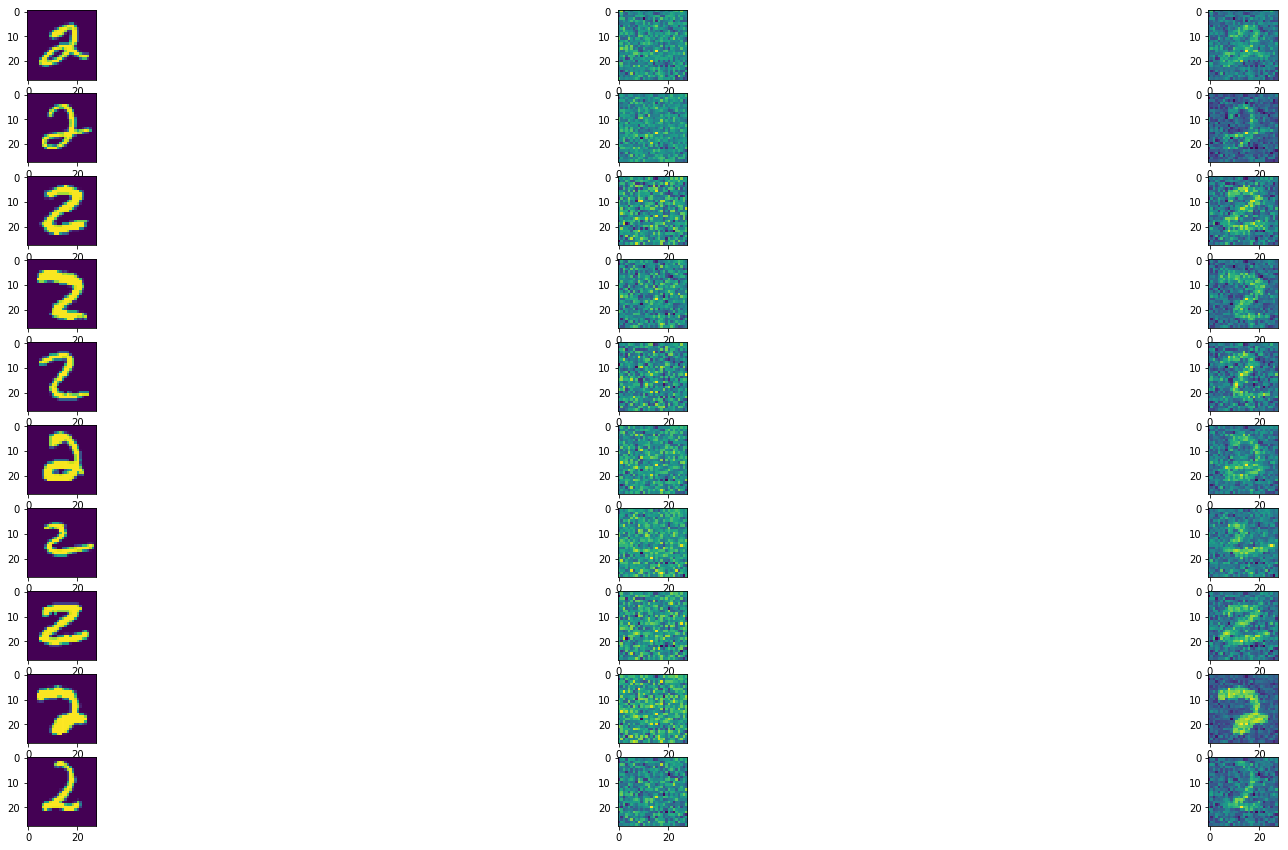

In [50]:
plot_figures(X_10_samples_2, X_10_noise)

### Trying AG approach

In [ ]:
def create_population(n):
    pop = []
    for i in range(n):
        individual = np.array([np.random.normal()/5 for _ in range(28*28)])
        pop.append(individual)
        
    return np.array(pop)

In [ ]:
pred = model.predict((X_10_noise))
for i in range(10):
    print( np.argmax( pred[i]) )

In [ ]:
180.15+(5*86.56)

In [ ]:
def evaluate_population(pop):
    ranking = []
    for individual in pop:
        X_10_noise = np.reshape(individual, (28, 28))
        new_element = (X_10_samples_2 + X_10_noise)
        individual = np.maximum(individual, 0)
        individual = np.minimum(individual, 1)

        pred = model.predict(new_element)
        value = np.sum(pred, axis=0)[6]
        ranking.append(value)
        
    return ranking

In [ ]:
def mutation(individual, probability):
    for i in range(len(individual)):
        if np.random.rand() < probability:
            individual[i] = individual[i] + np.random.normal()/10

    individual = np.maximum(individual, 0)
    individual = np.minimum(individual, 1)
    return np.array(individual)

def crossover(ind1 , ind2):
    position = np.random.randint(len(ind1))
    new_individual1 = np.concatenate((ind1[:position], ind2[position:]))
    new_individual2 = np.concatenate((ind2[:position], ind1[position:]))
    return np.array(new_individual1), np.array(new_individual2)

In [ ]:
num_epoch = 10000
pop_size = 1000

pop = create_population(pop_size)
best_val = []
best_number_of_six = []

for epoch in range(num_epoch):
    ranking = np.array(evaluate_population(pop))
    ordered_idx = ranking.argsort()
    pop_ordered = pop[ordered_idx]
    top5 = np.array(pop_ordered[-5:])
    other_ind = np.array(pop[ordered_idx][:-5])
    best_val.append(ranking[ordered_idx][-1])
    
    new_pop = []
    for _ in range(len(ordered_idx)):
        ind1 = other_ind[np.random.randint(len(other_ind))]
        ind2 = other_ind[np.random.randint(len(other_ind))]
        new_ind1, new_ind2 = crossover(ind1, ind2)
        new_pop.append(new_ind1)
        new_pop.append(new_ind2)
    
    pop_with_mutation = []
    for i in range(len(pop)-5):
        pop_with_mutation.append(mutation(new_pop[i], probability=0.05))

    pop = np.concatenate((top5, pop_with_mutation))
    if (epoch % 50)==0:
        for top in top5:
            top_noise = np.reshape(top, (28, 28))
            new_element = (X_10_samples_2 + top_noise)
            new_element = np.maximum(new_element, 0)
            new_element = np.minimum(new_element, 1)

            pred = model.predict(new_element)
            pred = np.array([np.argmax(pred[i]) for i in range(10)])
            value = np.sum(pred==6)
            best_number_of_six.append(value)
        print(epoch, ' - best value: ', best_val[len(best_val) - 1])
        print(best_number_of_six)
        print()
        
    if np.max(np.array(best_number_of_six)) == 10:
        break
    

ranking = np.array(evaluate_population(pop))
ordered_idx = ranking.argsort()
top5 = np.array(pop[ordered_idx][-5:])

print(top5)
print(ranking)
print(ranking[ordered_idx][-5])
print(best_val)

In [ ]:
X_10_noise = np.zeros((10, 28, 28))
for i in range(10):
    X_10_noise[i] = np.reshape(top5[0], (28,28))

new_element = (X_10_samples_2 + np.reshape(top5[0], (28,28)))
pred = model.predict(new_element)
pred = np.array([np.argmax(pred[i]) for i in range(10)])


print(pred)
plt.hist(X_10_samples_2[0], label='X_10_samples')
# plt.hist(X_10_noise[0], label='Noise')
plot_figures(X_10_samples_2, X_10_noise)

### Trying an Reinforcement Learning

In [ ]:
max_actions = (28*28*100)

def get_state(noise):
    noise = np.copy(noise)
    noise[noise>.9] = 1
    noise[noise<=.9 and noise>.8] = .9
    noise[noise<=.8 and noise>.7] = .8
    noise[noise<=.7 and noise>.6] = .7
    noise[noise<=.6 and noise>.5] = .6
    noise[noise<=.5 and noise>.4] = .5
    noise[noise<=.4 and noise>.3] = .4
    noise[noise<=.3 and noise>.2] = .3
    noise[noise<=.2 and noise>.1] = .2
    noise[noise<=.1 and noise>.0] = .1
    noise[noise<0] = 0
    
    return noise

def Q_function(state, noise, action):
    X_10_noise = np.reshape(individual, (28, 28))
    pred = model.predict((X_10_samples_2 + X_10_noise))
    value = np.sum(pred, axis=0)[6]
    
    return value


In [ ]:
def get_best_action(state):
    
    return 0

In [ ]:
num_train_times = 10

for num_train_time in range(num_train_times):
    initial_noise = np.array([np.random.normal()/5 for _ in range(28*28)])
    initial_state = get_state(initial_noise)
    state = np.array(initial_state)
    noise = np.array(initial_noise)
    
    for _ in range(max_actions):
        # Select an action (Explore or Exploit)
        action = -1
        if np.random.rand() < .2: # Explore
            action = np.random.randint((28*28))
        else:
            action = get_best_action(state)
        
        # Apply Action
        noise[action] = noise[action] + np.random.normal()/10
        # Getting Reward
        top_noise = np.reshape(noise, (28, 28))
        new_element = (X_10_samples_2 + top_noise)
        for pos in range(X_10_samples_2.shape[0]):
            for x in range(X_10_samples_2.shape[1]):
                for y in range(X_10_samples_2.shape[2]):
                    new_element[pos][x][y] = 0 if new_element[pos][x][y] < 0 else new_element[pos][x][y]
                    new_element[pos][x][y] = 1 if new_element[pos][x][y] > 1 else new_element[pos][x][y]

        pred = model.predict(new_element)
        pred = np.array([np.argmax(pred[i]) for i in range(10)])
        reward = np.sum(pred==6)
        if reward > 9.5:
            break
        
        # Update Q_Function
        # Generating new state
        state = get_state(noise)